In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import zipfile
import _pickle
import pickle
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_curve, auc, roc_auc_score
import time
import os
import peakutils

from ourfunctions_v3 import clean_nan_samples, remove_noise

In [5]:
# path = "D:/GitHub/Machine-Learning/Kaggle/"
path = 'C:/Users/Javi/Documents/GitHub/Machine-Learning/Kaggle/'
savepath = path + 'Kaggle classifiers/low area/'
path_results = path + 'Kaggle_results/'

ncpu = os.cpu_count()
if (ncpu>2): njobs = ncpu - 2; 
else: njobs = 1;
    
zf = zipfile.ZipFile(path+'zipped_TrainData.zip', 'r')
df_train = _pickle.loads(zf.open('TrainData.pkl').read())
zf.close()

zf = zipfile.ZipFile(path+'zipped_TestDataUnlabeled.zip', 'r')
df_test = _pickle.loads(zf.open('TestDataUnlabeled.pkl').read())
zf.close()

df_train = remove_noise(df_train)

# Extract data (spectra) and targets of the df_train set
data = df_train.iloc[:,-2:]
targets = df_train.iloc[:,1:-2]

# Then, split into a train and test_train set
data_train, data_test_train, targets_train, targets_test_train = train_test_split(data, targets, test_size=0.3, random_state=11) # split the data
print('Training samples: '+str(len(data_train))+' and test_train samples: ' + str(len(data_test_train)) )

Training sample 339  eliminated
Training sample 490  eliminated
Training samples: 359 and test_train samples: 155


In [6]:
def spectrum_in_bins_5(df, m, M, bin_size): # allows binsize < 1
    
    range_min = []; range_max = []; range_mean = []
    for mz in np.arange(m,M,bin_size):
        range_min.append(mz)
        range_max.append(mz+bin_size)
        range_mean.append(np.mean([range_min[-1],range_max[-1]]))
    N = len(df)  # number of samples
    L = len(range_min)  # length of new spectrum (number of bins)
    all_data = np.zeros((N,L))
    for idx in range(N):
        intensity = df[['intensity']].iloc[idx].values[0]
        mzcoord   = df[['coord_mz']].iloc[idx].values[0]
        idx_data_in_bins = np.zeros((1,L))
        for i,mz in enumerate(range_min):
            intensity_range = intensity[(mzcoord > mz) & (mzcoord < (mz+bin_size))]
            if len(intensity_range) > 0 :
                # as we are interested in peak values, let's keep the maximum value in the interval
                idx_data_in_bins[0,i] = np.max(intensity_range)
            else: # if those mz coordinates are not in that spectrum we interpolate
                idx_data_in_bins[0,i] = np.interp(x=range_mean[i],xp=mzcoord,fp=intensity)

        # Remove baseline
        idx_data_in_bins[0,:] -= peakutils.baseline(idx_data_in_bins[0,:],deg=4)
        # Normalize the amplitude of the spectrum
        idx_data_in_bins[0,:] = idx_data_in_bins[0,:] / np.max(idx_data_in_bins[0,:])
        # Store in matrix
        all_data[idx,:] = idx_data_in_bins
    new_df = pd.DataFrame(data=all_data, columns = range_mean, index = df.index)
    print('DONE!')
    return new_df

In [8]:
spectrum_train = spectrum_in_bins_5(data_train, 2000, 12000, 1)

DONE!


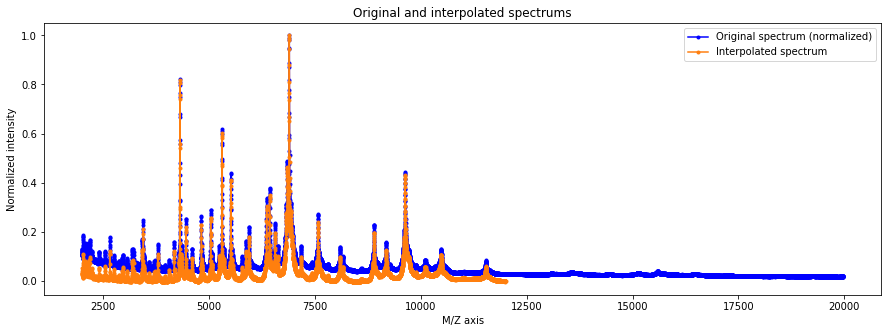

In [27]:
plt.figure(figsize=(15,5))
idx = 5
mzcoord = data_train[['coord_mz']].iloc[idx].values[0]
intensity = data_train[['intensity']].iloc[idx].values[0]
plt.plot(mzcoord,intensity/np.max(intensity),'b.-',label='Original spectrum (normalized)')
plt.plot(spectrum_train.columns.values, spectrum_train.iloc[idx,:],'C1.-', label='Interpolated spectrum')
plt.legend()
plt.xlabel('M/Z axis')
plt.ylabel('Normalized intensity')
plt.title('Original and interpolated spectrums')
plt.show()

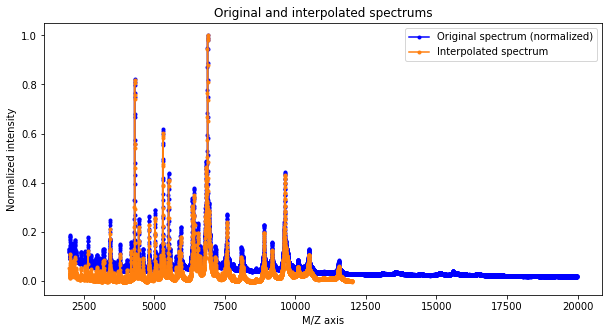

In [28]:
plt.figure(figsize=(10,5))
idx = 5
mzcoord = data_train[['coord_mz']].iloc[idx].values[0]
intensity = data_train[['intensity']].iloc[idx].values[0]
plt.plot(mzcoord,intensity/np.max(intensity),'b.-',label='Original spectrum (normalized)')
plt.plot(spectrum_train.columns.values, spectrum_train.iloc[idx,:],'C1.-', label='Interpolated spectrum')
plt.legend()
plt.xlabel('M/Z axis')
plt.ylabel('Normalized intensity')
plt.title('Original and interpolated spectrums')
plt.show()

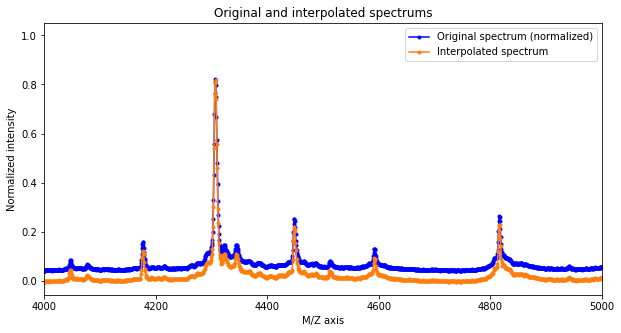

In [32]:
plt.figure(figsize=(10,5))
idx = 5
mzcoord = data_train[['coord_mz']].iloc[idx].values[0]
intensity = data_train[['intensity']].iloc[idx].values[0]
plt.plot(mzcoord,intensity/np.max(intensity),'b.-',label='Original spectrum (normalized)')
plt.plot(spectrum_train.columns.values, spectrum_train.iloc[idx,:],'C1.-', label='Interpolated spectrum')
plt.legend()
plt.xlabel('M/Z axis')
plt.ylabel('Normalized intensity')
plt.title('Original and interpolated spectrums')
plt.xlim((4000,5000))
plt.show()

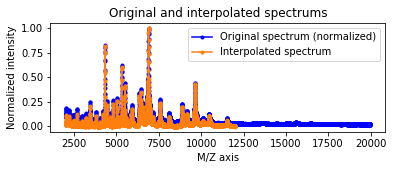

In [31]:
plt.figure(figsize=(6,2))
idx = 5
mzcoord = data_train[['coord_mz']].iloc[idx].values[0]
intensity = data_train[['intensity']].iloc[idx].values[0]
plt.plot(mzcoord,intensity/np.max(intensity),'b.-',label='Original spectrum (normalized)')
plt.plot(spectrum_train.columns.values, spectrum_train.iloc[idx,:],'C1.-', label='Interpolated spectrum')
plt.legend()
plt.xlabel('M/Z axis')
plt.ylabel('Normalized intensity')
plt.title('Original and interpolated spectrums')
plt.show()

# Peaks + Low area magnification


In [33]:
def spectrum_in_bins_lowareamagnification(df,m,middle,M,bin_size_lowarea,bin_size):
    # Lowarea
    range_min_lowarea = []; range_max_lowarea = []; range_mean_lowarea = []
    for mz in np.arange(m,middle,bin_size_lowarea):
        range_min_lowarea.append(mz)
        range_max_lowarea.append(mz+bin_size_lowarea)
        range_mean_lowarea.append(np.mean([range_min_lowarea[-1],range_max_lowarea[-1]]))

    N = len(df)  # number of samples
    L = len(range_min_lowarea)  # length of new spectrum (number of bins)
    all_data = np.zeros((N,L))
    for idx in range(N):
        intensity = df[['intensity']].iloc[idx].values[0]
        mzcoord   = df[['coord_mz']].iloc[idx].values[0]
        idx_data_in_bins = np.zeros((L,))
        for i,mz in enumerate(range_min_lowarea):
            intensity_range = intensity[(mzcoord > mz) & (mzcoord < (mz+bin_size_lowarea))]
            if len(intensity_range) > 0 :
                # as we are interested in peak values, let's keep the maximum value in the interval
                idx_data_in_bins[i] = np.max(intensity_range)
            else: # if those mz coordinates are not in that spectrum we interpolate
                idx_data_in_bins[i] = np.interp(x=range_mean_lowarea[i],xp=mzcoord,fp=intensity)

        # Remove baseline
        idx_data_in_bins -= peakutils.baseline(idx_data_in_bins,deg=4)
        # Normalize the amplitude of the spectrum
        idx_data_in_bins = idx_data_in_bins / np.max(idx_data_in_bins)
        # Store in matrix
        all_data[idx,:] = idx_data_in_bins.reshape(1, -1)
    new_df_lowarea = pd.DataFrame(data=all_data, columns = range_mean_lowarea, index = df.index)    
    print('Low area finished')


    # High area    
    range_min = []; range_max = []; range_mean = []
    for mz in np.arange(middle,M,bin_size):
        range_min.append(mz)
        range_max.append(mz+bin_size)
        range_mean.append(np.mean([range_min[-1],range_max[-1]]))

    N = len(df)  # number of samples
    L = len(range_min)  # length of new spectrum (number of bins)
    all_data = np.zeros((N,L))
    for idx in range(N):
        intensity = df[['intensity']].iloc[idx].values[0]
        mzcoord   = df[['coord_mz']].iloc[idx].values[0]
        idx_data_in_bins = np.zeros((L,))
        for i,mz in enumerate(range_min):
            intensity_range = intensity[(mzcoord > mz) & (mzcoord < (mz+bin_size))]
            if len(intensity_range) > 0 :
                # as we are interested in peak values, let's keep the maximum value in the interval
                idx_data_in_bins[i] = np.max(intensity_range)
            else: # if those mz coordinates are not in that spectrum we interpolate
                idx_data_in_bins[i] = np.interp(x=range_mean[i],xp=mzcoord,fp=intensity)

        # Remove baseline
        idx_data_in_bins -= peakutils.baseline(idx_data_in_bins,deg=4)
        # Normalize the amplitude of the spectrum
        idx_data_in_bins = idx_data_in_bins / np.max(idx_data_in_bins)
        # Store in matrix
        all_data[idx,:] = idx_data_in_bins.reshape(1, -1)
    new_df = pd.DataFrame(data=all_data, columns = range_mean, index = df.index)
    print('High area finished')

    merged_spectrum = pd.concat([new_df_lowarea,new_df],axis=1)
    print('DONE!')
    return merged_spectrum

In [44]:
m = 2000
middle = 4000
M = 12000
bin_size = 1
bin_size_lowarea = 1
spectrum_train_magnif = spectrum_in_bins_lowareamagnification(data_train,m,middle,M,bin_size_lowarea,bin_size)

Low area finished
High area finished
DONE!


In [45]:
def spectrum_in_peaks(spectrum,peaks):
    df = spectrum.copy()
    spectrum  = spectrum.to_numpy()
    new_spectrum = np.zeros((spectrum.shape[0],len(peaks)))
    
    for i,x in enumerate(spectrum):
      spectrum_train_aux = x[peaks]
      new_spectrum[i,:] = spectrum_train_aux

    new_df = pd.DataFrame(data=new_spectrum, columns = df.columns.values[peaks], index = df.index)
    return new_df

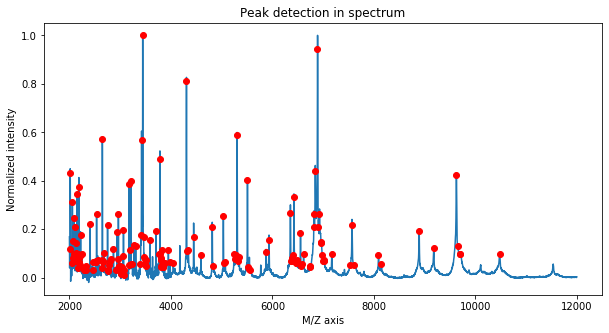

In [49]:
mean_spectrum = np.mean(spectrum_train_magnif.to_numpy(),axis=0)
peaks = peakutils.peak.indexes(mean_spectrum,thres=0.05)
peaks_spectrum_train = spectrum_in_peaks(spectrum_train_magnif, peaks)

idx = 5
plt.figure(figsize=(10,5))
plt.plot(spectrum_train_magnif.columns.values, spectrum_train_magnif.iloc[idx,:])
plt.plot(peaks_spectrum_train.columns.values, peaks_spectrum_train.iloc[idx,:],'ro')
# plt.legend()
plt.xlabel('M/Z axis')
plt.ylabel('Normalized intensity')
plt.title('Peak detection in spectrum')
plt.show()